In [147]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [148]:
raw_data = pd.read_csv("bq_slot_data_1000.csv")
raw_data = raw_data.rename(
    columns = {
        "end_timestamp":"ds","total_lamports":"y"
        }
        )
raw_data.index = pd.to_datetime(raw_data["ds"]).dt.tz_localize(None)
raw_data.drop(columns = {'ds'},inplace=True)
raw_data["y"] = raw_data["y"]/1000

raw_data = pd.DataFrame({"y":raw_data["y"]})
raw_data = np.log(raw_data/raw_data.shift(1))
raw_data = raw_data.dropna()

raw_data


,y
ds,
2025-05-22 11:28:30,0.672913
2025-05-22 11:21:58,0.072377
2025-05-22 11:15:23,-0.247962
2025-05-22 11:08:48,0.040522
2025-05-22 11:02:13,-0.003816
...,...
2024-03-25 12:40:08,0.068994
2024-03-25 12:33:01,-0.135073
2024-03-25 12:25:58,-0.001210


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -164743.
Distribution:                  Normal   AIC:                           329495.
Method:            Maximum Likelihood   BIC:                           329532.
                                        No. Observations:                82639
Date:                Wed, May 28 2025   Df Residuals:                    82638
Time:                        10:10:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0133  7.912e-03      1.678  9.327e-02 

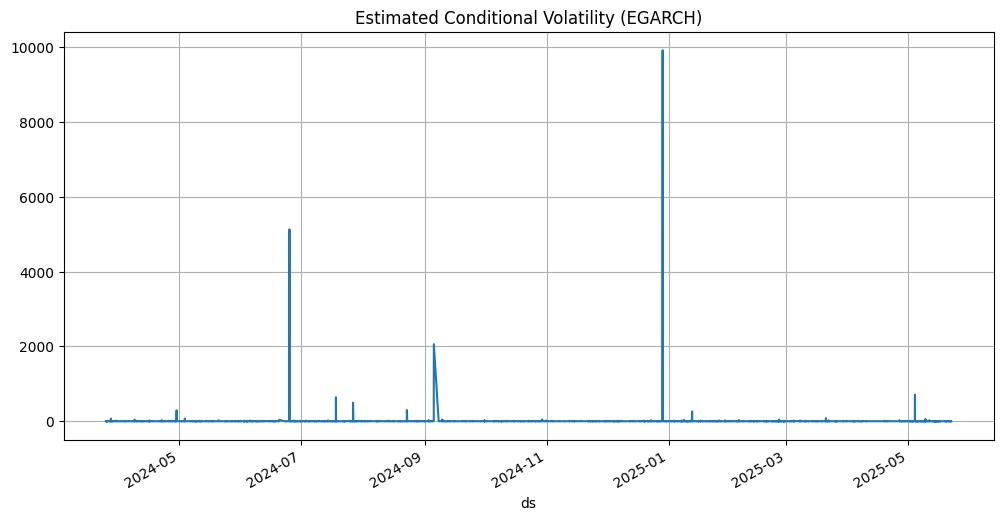

In [ ]:
model = arch_model(
    raw_data["y"],
    vol='EGARCH',
    p=1,
    q=1,
    mean='Constant',
    rescale=True
)

results = model.fit(disp="off")

print(results.summary())

forecast = results.forecast(horizon=1, start=None)  # prédiction one-step-ahead
vol_forecast = forecast.variance.iloc[-1, 0]**0.5
print(f"Prévision de la volatilité au prochain pas : {vol_forecast}")


# Variance conditionnelle estimée
volatility_series = results.conditional_volatility
volatility_series.name = "SOL_volatility"


import matplotlib.pyplot as plt

volatility_series.plot(figsize=(12,6), title="Estimated Conditional Volatility (EGARCH)")
plt.grid()
plt.show()

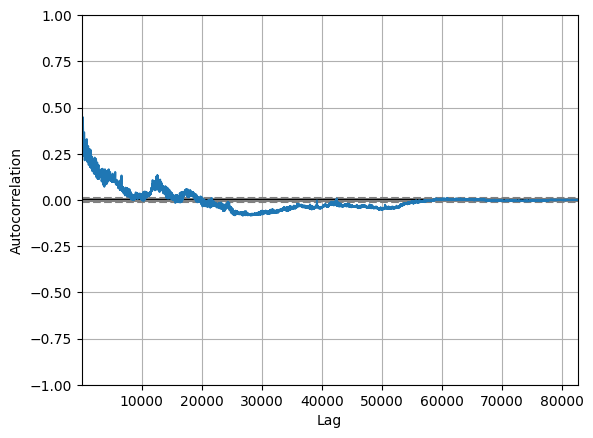

In [140]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(serie1)
plt.show()

In [141]:

####################### Data Split ###############################################################################################################################
data = raw_data.copy().sort_index()
data_train = data[data.index < datetime(2025,1,1)]
data_test = data[data.index >= datetime(2025,1,1)]




In [142]:
history = [x for x in data_train["y"]]
predictions = list()
# walk-forward validation
for t in range(len(data_test["y"])):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = data_test["y"][t]
	history.append(obs)
	print(data_test.index[t])
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(data_test["y"], predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(data_test["y"])
plt.plot(predictions, color='red')
plt.show()

/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/var/folders/ky/bkmw074j5j5_ss2q259cfpq80000gn/T/ipykernel_44458/4071761227.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = data_test["y"][t]


2025-01-01 00:05:42
predicted=0.010482, expected=0.038996
2025-01-01 00:12:35
predicted=-0.077258, expected=0.112706


KeyboardInterrupt: 

In [ ]:
m = Prophet()

m.fit(data_train[["y","ds"]])

future = pd.DataFrame(data = {"ds":data_test["ds"]})
print(future)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1550: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/hamzamuhammad/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1550: RuntimeWarning: overflow encountered in matmul

                       ds
29887 2025-01-01 00:05:42
29886 2025-01-01 00:12:35
29885 2025-01-01 00:19:23
29884 2025-01-01 00:26:12
29883 2025-01-01 00:33:01
...                   ...
4     2025-05-22 11:08:48
3     2025-05-22 11:15:23
2     2025-05-22 11:21:58
1     2025-05-22 11:28:30
0     2025-05-22 11:32:44

[29888 rows x 1 columns]


,ds,yhat,yhat_lower,yhat_upper
0,2025-01-01 00:05:42,3.661821e+07,1.241908e+07,6.103413e+07
1,2025-01-01 00:12:35,3.628616e+07,1.166559e+07,6.270674e+07
2,2025-01-01 00:19:23,3.596721e+07,1.223364e+07,6.114096e+07
3,2025-01-01 00:26:12,3.565706e+07,1.130646e+07,5.919299e+07
4,2025-01-01 00:33:01,3.535687e+07,1.142160e+07,6.146485e+07
...,...,...,...,...
29883,2025-05-22 11:08:48,-1.353485e+08,-9.678523e+08,6.965770e+08
29884,2025-05-22 11:15:23,-1.351785e+08,-9.678301e+08,6.995935e+08
29885,2025-05-22 11:21:58,-1.349872e+08,-9.575888e+08,6.986114e+08
29886,2025-05-22 11:28:30,-1.347757e+08,-9.628293e+08,7.089170e+08


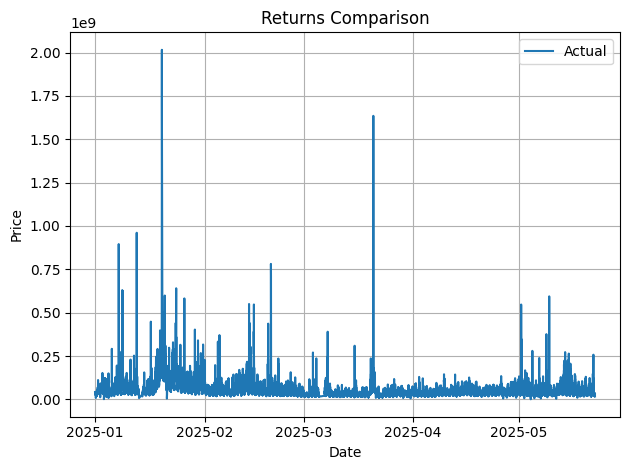

In [ ]:

#plt.plot(forecast["ds"],forecast["yhat"],label = "Prediction")
plt.plot(forecast["ds"],data_test["y"],label = "Actual")
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

